In [20]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN, A2C, DDPG
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from utils import polygon_to_metres, resize_polygon, polygon_to_Poly3DCollection
from collections import defaultdict

print(gym.__version__)

0.29.1


Timeline \
<input type="checkbox" checked/> add clavon and a few other sites polygons \
<input type="checkbox" checked/> prepare the buildings to be added in \
<input type="checkbox" checked/> Added a function to convert a building polygon into a Poly3DCollection for plotting polygons \
<input type="checkbox"> transfer state from env.boxes to env.building_list \
<input type="checkbox"/> change the environment to just xy \
<input type="checkbox"/> run the script on research cluster \
<input type="checkbox"/> Write evaluation script for interblock distance in inference, out of site, collision (Clarence)\
<input type="checkbox"/> Add GFA function\
<input type="checkbox" checked/> convert polygon into metres (Clarence)\
<input type="checkbox"/> scale the sites to the real life dimensions \
<input type="checkbox"/> Get the interblock distance for those sites, 30m for bedroom facing, 10m for bedroom not facing\
<input type="checkbox"/> add angle for the blocks, so action space is x,y,theta \
<input type="checkbox"/> Refactor environment code \
<input type="checkbox"/> write the feature extractor for the clavon site \
<input type="checkbox"/> Block view objective reward function \
<input type="checkbox"/> Get the context for each site \
<input type="checkbox"/> add a generative loss 

# Util functions for input data


In [2]:
# sting = '103.9184733 1.3092462, 103.9185355 1.3092515, 103.9185338 1.3092714, 103.9186415 1.3092804, 103.9186431 1.3092613, 103.9187158 1.3092674, 103.9187202 1.3092156, 103.9187321 1.3092166, 103.9187379 1.3091466, 103.9186642 1.3091404, 103.9186697 1.3090749, 103.9187467 1.3090814, 103.9187526 1.3090106, 103.9187395 1.3090095, 103.9187444 1.3089509, 103.9186749 1.3089451, 103.9186763 1.3089285, 103.9185696 1.3089195, 103.9185683 1.3089349, 103.9185011 1.3089292, 103.9184967 1.3089811, 103.9184756 1.3089793, 103.9184691 1.3090564, 103.918545 1.3090628, 103.9185392 1.3091312, 103.9184654 1.3091249, 103.9184593 1.3091968, 103.9184773 1.3091984, 103.9184733 1.3092462'
#replace "' "with ","


geo_list = [
    [0,0],
    [0,1.1],
    [1.5,1.1],
    [1.5,2],
    [0,2],
    [0,3],
    [7,3],
    [7,2],
    [5,2],
    [5,1.1],
    [7,1.1],
    [7,0],
    [4.5,0],
    [4.5,0.5],
    [3.5,0.5],
    [3.5,0],
    [0,0]
]

geo_list = [f'{x[0]} {x[1]}' for x in geo_list]
geo = ', '.join(geo_list)

sting = geo.replace(", ",",")
string_list = sting.split(",")
# print(string_list)
string_list = ["("+ string_list[i].replace(" ",",") + ")" for i in range(len(string_list))]
string = "("+ ",".join(string_list) + ")"
print(string)

((0,0),(0,1.1),(1.5,1.1),(1.5,2),(0,2),(0,3),(7,3),(7,2),(5,2),(5,1.1),(7,1.1),(7,0),(4.5,0),(4.5,0.5),(3.5,0.5),(3.5,0),(0,0))


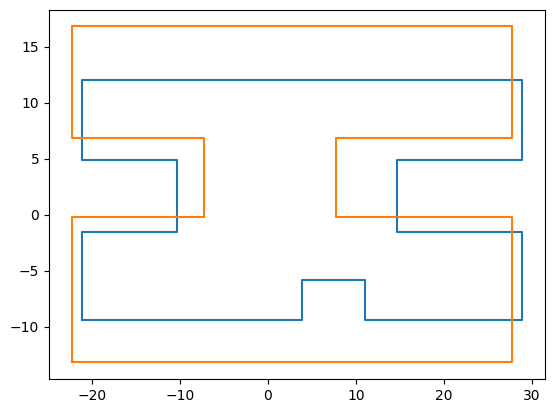

In [3]:
sites_list = [Polygon(((103.76762137358979,1.3087990670131122),(103.76695888021099,1.3091033941901744),(103.76695888021099,1.3091033941901782),(103.76680089609894,1.3087280864870512),(103.76679274742034,1.3087078172631332),(103.76678557945053,1.3086899861164933),(103.76677812454516,1.3086684317627417),(103.76677122299097,1.3086453681151176),(103.7667670091718,1.308629112978794),(103.76676302875474,1.308610442969295),(103.76675844145478,1.3085858620102093),(103.76675564607066,1.308568042468877),(103.7667533421893,1.3085446293791023),(103.76675190226392,1.3085256723620893),(103.76675180617868,1.3085231659641638),(103.76675217242752,1.3085144072545394),(103.7667522007742,1.3084925885686336),(103.76675194337425,1.3084860243757694),(103.76675179918865,1.3084809478597594),(103.7667517106069,1.3084758790108302),(103.7667516777277,1.3084708192010914),(103.76675170047343,1.3084657425356094),(103.76675178278158,1.3084603788857558),(103.76675190539342,1.3084553122515075),(103.76675209415393,1.3084502477405577),(103.76675234045226,1.3084448982895578),(103.76675262913469,1.3084398468137872),(103.76675297264875,1.3084347980204762),(103.76675337164095,1.308429760924249),(103.7667538265147,1.3084247131985483),(103.76675436383049,1.3084194076934133),(103.76675492029798,1.3084143621108462),(103.76675554278873,1.3084093157891215),(103.76675623518352,1.3084040881540013),(103.76675695186114,1.3083991144012195),(103.76675772636361,1.3083941199926599),(103.7667585981971,1.3083888850082213),(103.76675947173706,1.3083839153246697),(103.76676040667252,1.3083789760982625),(103.76676143482773,1.3083738029708472),(103.76676252125338,1.3083686400989731),(103.76676359985571,1.3083637364392524),(103.76676473694107,1.3083588713631675),(103.76676598859025,1.3083537327630061),(103.76676721542269,1.3083489250335345),(103.7667685661309,1.30834388081516),(103.76676998123311,1.3083387781575588),(103.7667713777606,1.3083339540246992),(103.76677288501628,1.3083289535549412),(103.76677431495274,1.3083243728196843),(103.76677594002432,1.308319412844347),(103.7667776044232,1.3083144450305626),(103.76677923565617,1.3083097919766917),(103.76678109463339,1.3083046375442602),(103.76678287287089,1.3082998556296206),(103.76678465129328,1.3082952392626963),(103.76678653966118,1.3082904938452273),(103.7667884690412,1.3082857914938295),(103.76679050494603,1.3082809810350113),(103.76679265220022,1.3082760417058086),(103.76679468914062,1.3082714786919092),(103.76679669853525,1.3082671254202085),(103.76679893802313,1.308262412675837),(103.76680124155497,1.3082576830310426),(103.76680345530123,1.3082532600238392),(103.76680579233569,1.3082487256194255),(103.76680831269016,1.3082439502444518),(103.76681077662153,1.308239388683786),(103.76681316405632,1.3082350862344916),(103.76681367260619,1.3082341941146542),(103.7670369584743,1.307915310591265),(103.7670369584743,1.3079153105912689),(103.76766580058731,1.308298877127881),(103.76766580058731,1.3082988771278814),(103.7676428514021,1.3083818967566208),(103.76764179810895,1.3083863255490304),(103.76762282479181,1.3084812464296733),(103.7676218261851,1.3084883025243677),(103.76761371619476,1.30858474385251),(103.76761349686825,1.3085895323950083),(103.76761275665643,1.3086863455250057),(103.76761291779121,1.3086913506228472),(103.7676198824296,1.308787898815235),(103.7676204205505,1.3087927382936007),(103.76762137358979,1.3087990670131138))),
              Polygon(((103.76881799558069,1.3113251436959874),(103.76881140669404,1.3113255727539448),(103.76873396113677,1.3113315665393301),(103.76872784263504,1.3113321102857496),(103.76865738056709,1.3113391824336829),(103.76839126471891,1.3113533462825622),(103.76838106854085,1.3113540831328867),(103.76835900052754,1.3113560993222997),(103.76833891785218,1.3113586981033494),(103.76831699267106,1.3113623775367729),(103.76830393468646,1.3113649016606184),(103.76822916610874,1.311381278147748),(103.76822326065329,1.3113826413806544),(103.76814908496362,1.3114006451884348),(103.76814328579329,1.3114021211198539),(103.76806951434554,1.3114217711079816),(103.76806369241301,1.3114233919786933),(103.76805063357534,1.3114271859332673),(103.76805063357534,1.3114271859332676),(103.76793435831124,1.3112195678874503),(103.76785570785277,1.3110483549485854),(103.767854909063,1.3110466321041037),(103.76783283523227,1.3109994591068697),(103.76778345246646,1.3108599918491781),(103.7677810570058,1.310853493215834),(103.76777568418207,1.3108394750826222),(103.76777019997111,1.310826231496659),(103.76776409052887,1.3108125214049136),(103.76776114891919,1.3108061449635922),(103.7677035103156,1.3106853657516602),(103.7676989924413,1.3106763377694812),(103.76768916217716,1.3106575804661729),(103.7676792703816,1.3106402915368032),(103.76766809354281,1.3106223308305385),(103.76766267840111,1.3106139769623915),(103.76760055230274,1.3105219074519354),(103.76759480278204,1.3105107430616825),(103.767537054323,1.3103985563959337),(103.76752057039474,1.310366533902596),(103.76751937486969,1.3103642385678935),(103.76744440558485,1.3102219736491236),(103.76743225026283,1.310198905858367),(103.76743066661837,1.3101959453563914),(103.76734150792808,1.3100317376402688),(103.7673397693827,1.3100285860524563),(103.76725723774882,1.3098813090027575),(103.76702004307234,1.309318039510132),(103.76702004307234,1.3093180395101274),(103.76767692458766,1.309016942764499),(103.76767692458766,1.3090169427645042),(103.76769177935024,1.3090558434512203),(103.76769263097744,1.309057957826232),(103.7677184530503,1.3091188584835525),(103.7677193520865,1.3091208791988285),(103.76797250724987,1.3096639600470876),(103.76798035681244,1.309681308153539),(103.76810629485455,1.309959512084365),(103.7681429619824,1.3100405173730216),(103.76818872560791,1.3101416202506384),(103.76824352221166,1.3102626758022258),(103.76824440209765,1.310264537846306),(103.76830279528608,1.3103830476364076),(103.76830295441698,1.3103833682895258),(103.76834752882135,1.3104725485665667),(103.76834849990372,1.3104744128344818),(103.76839591388273,1.3105618391575204),(103.76839618181492,1.3105623280126735),(103.76844411771513,1.3106488769082296),(103.76844515425438,1.3106506775505256),(103.76849661155047,1.3107367468682052),(103.76849738485257,1.3107380064697685),(103.76855069357646,1.3108225930541009),(103.76855129084,1.3108235225460931),(103.76860488702482,1.3109053421425187),(103.76860502290766,1.3109055486933838),(103.76865875501163,1.3109868763656687),(103.76870692933043,1.311070285492092),(103.76875105891605,1.3111566848241125),(103.76878968068795,1.311244243504477),(103.76881799558069,1.3113251436959852))),
            # Polygon(((103.9502369,1.3283904),(103.9505232,1.3277247),(103.9525938,1.3285024),(103.9521837,1.3291431),(103.9519125,1.3294435),(103.9502369,1.3283904))),
            #  Polygon(((103.9347477,1.3384172),(103.9347544,1.3383448),(103.9347819,1.3382832),(103.9349328,1.338078),(103.935199,1.3377301),(103.9353338,1.3374975),(103.9354324,1.3372696),(103.9355048,1.3370671),(103.9355476,1.3368769),(103.9376767,1.3371135),(103.9355323,1.3391707),(103.9351487,1.3387645),(103.9347692,1.3384742),(103.9347477,1.3384172))),
            #  Polygon(((103.9544223,1.3204243),(103.9545532,1.3201771),(103.9545116,1.3201523),(103.9547401,1.3197211),(103.9553594,1.3200968),(103.9548355,1.3208367),(103.9547314,1.320636),(103.9544223,1.3204243)))]#plot pologon
            ]   

building_list = [Polygon(((0,0),(0,1.1),(1.5,1.1),(1.5,2),(0,2),(0,3),(7,3),(7,2),(5,2),(5,1.1),(7,1.1),(7,0),(4.5,0),(4.5,0.5),(3.5,0.5),(3.5,0),(0,0))),
                #  Polygon(((103.9182582,1.3085852),(103.9183205,1.3085905),(103.9183188,1.3086104),(103.9184265,1.3086194),(103.9184281,1.3086003),(103.9185008,1.3086064),(103.9185052,1.3085546),(103.918517,1.3085556),(103.9185229,1.3084856),(103.9184491,1.3084794),(103.9184547,1.3084139),(103.9185317,1.3084204),(103.9185376,1.3083497),(103.9185245,1.3083486),(103.9185294,1.30829),(103.9184599,1.3082841),(103.9184613,1.3082676),(103.9183545,1.3082586),(103.9183532,1.3082739),(103.9182861,1.3082683),(103.9182817,1.3083201),(103.9182606,1.3083183),(103.9182541,1.3083954),(103.91833,1.3084018),(103.9183242,1.3084702),(103.9182504,1.308464),(103.9182443,1.3085359),(103.9182623,1.3085374),(103.9182582,1.3085852))),
                #  Polygon(((103.9180943,1.309182),(103.9182393,1.3091933),(103.9182464,1.3091028),(103.9182956,1.3091066),(103.9183064,1.308967),(103.9181121,1.3089519),(103.9180943,1.309182))),
                 Polygon(((0,0),(0,1.3),(1.5,1.3),(1.5,2),(0,2),(0,3),(5,3),(5,2),(3,2),(3,1.3),(5,1.3),(5,0),(0,0)))
                ]   

fig, ax = plt.subplots()
for building in building_list:
    building_polygon = resize_polygon(building, desired_scale=50)
    X, Y = building_polygon.exterior.xy

    ax.plot(X,Y)

plt.show()

# RL Class


In [104]:
class SpaDesPlacement(gym.Env):
    def __init__(self,sites_list, building_list, grid_size=(50, 50), max_boxes=20, site_coverage= 0.3, interblock_distance=1, grid_to_metre_ratio = 5):
        """
        This is the environment for SpaDes spatial design studio project. Generate site proposals given a site 
        Inputs:
            sites_list (List[Polygon]): List of polygons representing the sites in lat long 
            building_list (List[Polygon]): List of polygons representing the buildings in metres 
            grid_size (Tuple[int, int]): Size of the grid (width, height)
            max_boxes (int): Maximum number of boxes to place
            site_coverage (float): Maximum site coverage (between 0 and 1)
            interblock_distance (float): Minimum distance between blocks
            grid_to_metre_ratio (float): represents how much a pixel in the grid represents in metres
        """
        super(SpaDesPlacement, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes
        self.site_coverage = site_coverage

        # convert each site to metres first, before scaling and centering it 
        grid_center = (self.grid_size[0]/2,self.grid_size[1]/2)
        self.sites_list = [resize_polygon(polygon_to_metres(site),multiplier=1/grid_to_metre_ratio,center=grid_center) for site in sites_list]
        self.site_boundary = self._get_random_site(self.sites_list)
        self.building_list = building_list
        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,3,3,1]), high=np.array([1,1,7,7,9]), shape=(5,), dtype=float)
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes*(self.action_space.shape[0]) + 200 + 3 ) # 200:coordinate of site_boundary,3 : constraints
        # self.observation_space = spaces.Box(0,200,shape=(np.prod(self.grid_size) + max_boxes,0), dtype= np.float32)                                 

        self.boxes_placed = 0
        self.boxes = np.empty((1,5), dtype=float)
        self.interblock_distance = interblock_distance
        self.total_footprint =0
        self.state = self._get_state()

    def reset(self, seed=1):
        self.boxes_placed = 0
        self.total_footprint = 0
        self.site_coverage = np.random.uniform(0.2, 0.4)
        self.interblock_distance = np.random.uniform(1, 3)
        self.site_boundary = self._get_random_site(self.sites_list)

        # grid is a NxN matrix, where N is the size in init
        self.boxes = np.empty((1,5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes * self.action_space.shape[0])
        self.state = np.concatenate([flat_grid, box_count,self.pad_polygon(self.site_boundary, 100),[self.site_coverage, self.max_boxes, self.interblock_distance]])
        return self.state, {}

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, -1, True, None, {}
        
        if not self._is_valid_site_coverage():
            return self.state, -5, True, None, {}

        x, y, width, length, height = action
        x, y, width, length, height  = math.floor(x*49.8), math.floor(y*49.8), width, length, height
        reward = 5
        if not self.site_boundary.contains(Polygon([(x, y),(x + width, y),(x + width, y + length),(x, y + length),(x, y)])):
            reward = -1

        if not self._is_valid_placement(x, y, width, length, height):
            reward = -5

        box = np.array([[x, y, width, length, height]])
        self.boxes = np.append(self.boxes, box, axis=0)
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()
        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, None, {}
    
    def calculate_intersection_volume(self,box1, box2):
        x_overlap = max(0, min(box1[0] + box1[2], box2[0] + box2[2]) - max(box1[0] , box2[0] ))
        y_overlap = max(0, min(box1[1] + box1[3], box2[1] + box2[3]) - max(box1[1], box2[1]))
        z_overlap = max(0, min(box1[4], box2[4]) - max(box1.z, box2.z))

        intersection_volume = x_overlap * y_overlap * z_overlap
        return intersection_volume
    

    def calculate_clear_view_reward(self,box, other_boxes, offset = 5):
        # Calculate surrounding area for the given box
        offset_left = [box[0] - offset, box[1], offset, box[3], box[4]]
        offset_right = [box[0]+box[2],box[1],offset,box[3], box[4]]
        offset_bottom = [box[0],box[1]-offset,box[2],offset,box[4]]
        offset_top = [box[0],box[1]+box[3],box[2],offset,box[4]]
        
        for other_box in other_boxes:
            intersection_volume = self.calculate_intersection_volume(box, other_box)
            if intersection_volume > 0:
                # If there is an intersection, return a reward based on the clear view volume (between 0 and 1)
                clear_view_volume = (box.width * box.height * box.depth) - intersection_volume
                reward = clear_view_volume / (box.width * box.height * box.depth)
                return max(0, min(1, reward))
        return 1    

    def _is_valid_placement(self, x, y, width, length, height):
        # Check if the placement is valid (no intersection with other boxes)
        new_box = Polygon([(x, y),(x + width, y),(x + width, y + length),(x, y + length),(x, y)])
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            
            current_box = Polygon([(box[0] - self.interblock_distance, box[1] - self.interblock_distance),
                                   (box[0] + box[2] + self.interblock_distance, box[1] - self.interblock_distance),
                                   (box[0] + box[2] + self.interblock_distance, box[1] + box[3] + self.interblock_distance),
                                   (box[0] - self.interblock_distance, box[1] + box[3] - self.interblock_distance),
                                   (box[0] - self.interblock_distance, box[1] - self.interblock_distance)])
            if new_box.intersects(current_box):
                return False
        return True

    def pad_polygon(self,polygon, target_length):
            current_length = len(polygon.exterior.xy[0])
            padding_length = max(0, target_length - current_length)
            padded_vertices_x = list(polygon.exterior.xy[0]) + [0] * padding_length
            padded_vertices_y = list(polygon.exterior.xy[1]) + [0] * padding_length
            
            return np.array(padded_vertices_x +  padded_vertices_y)
    
    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        boxes = self.boxes[1:]
        box_count = np.zeros(self.max_boxes * self.action_space.shape[0])
        pad_box = self.max_boxes - self.boxes_placed
        for i in range(self.boxes_placed):
            start = i * self.action_space.shape[0]
            box_count[start] = boxes[i][0]
            box_count[start+1] = boxes[i][1]
            box_count[start+2] = boxes[i][2]
            box_count[start+3] = boxes[i][3]
            box_count[start+4] = boxes[i][4]
        
        # return {'grid':np.concatenate([flat_grid, box_count]),'site_boundary': site_boundary}
        return np.concatenate([flat_grid, box_count,self.pad_polygon(self.site_boundary,100),[self.site_coverage, self.max_boxes, self.interblock_distance]])
    
    def _is_valid_site_coverage(self):
        self.total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            self.total_footprint += box_footprint
        
        if (self.total_footprint/self.site_boundary.area > self.site_coverage):          
            self.boxes=self.boxes[:-1]
            return False
        
        return True
    
    def _get_random_site(self,sites_list):
        site = sites_list[random.randint(0,len(sites_list)-1)]
        return site
    
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        for i in range(len(self.boxes)):
            x = self.boxes[i][0]
            y = self.boxes[i][1]
            length = self.boxes[i][2]
            width = self.boxes[i][3]
            height = self.boxes[i][4]
            # building = self.building_list

            # polygon_x, polygon_y = building.exterior.xy
            # START: Replace with building_list once ready
            building_polygon = Polygon(((103.9370357, 1.3143551),
                (103.9370357, 1.3129232),
                (103.9372625, 1.3129232),
                (103.9372625, 1.3134300),
                (103.9375333, 1.3134300),
                (103.9375333, 1.3129232),
                (103.9377601, 1.3129232),
                (103.9377601, 1.3143551),
                (103.9375333, 1.3143551),
                (103.9375333, 1.3139200),
                (103.9372625, 1.3139200),
                (103.9372625, 1.3143551),
                (103.9370357, 1.3143551)
            ))

            site_polygon = resize_polygon(building_polygon,desired_scale=5,center=(x,y))
            # END: Replace with building_list once ready
            poly3d = polygon_to_Poly3DCollection(site_polygon, height)
            ax.add_collection3d(poly3d)

        ax.plot(list(self.site_boundary.exterior.xy[0]),list(self.site_boundary.exterior.xy[1])  , alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([0, self.grid_size[0]])
        ax.set_ylim([0, self.grid_size[1]])
        ax.set_zlim([0, 10])
        plt.show()
        print(self.state)
        self.total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            self.total_footprint += box_footprint
        print('site coverage ', self.total_footprint/self.site_boundary.area)

    def get_info(self):
        # for building in self.building_list:
        #     print(building.exterior.xy)
        self.building_list=[]
        for i in range(len(self.boxes)):
            # START: TO REPLACE ONCE BUILDING LIST IS READY
            x = self.boxes[i][0]
            y = self.boxes[i][1]
            length = self.boxes[i][2]
            width = self.boxes[i][3]
            height = self.boxes[i][4] 
            building_polygon = Polygon(((103.9370357, 1.3143551),
                (103.9370357, 1.3129232),
                (103.9372625, 1.3129232),
                (103.9372625, 1.3134300),
                (103.9375333, 1.3134300),
                (103.9375333, 1.3129232),
                (103.9377601, 1.3129232),
                (103.9377601, 1.3143551),
                (103.9375333, 1.3143551),
                (103.9375333, 1.3139200),
                (103.9372625, 1.3139200),
                (103.9372625, 1.3143551),
                (103.9370357, 1.3143551)
            ))
            building_polygon = resize_polygon(building_polygon,desired_scale=5,center=(x,y))
            self.building_list.append(building_polygon)
            # END: TO REPLACE ONCE BUILDING LIST IS READY
        # check the number of buildings who intersect with each other based on interblock distance and collide with each other 
        n_collisions = 0 
        n_violate_interblock_distance = 0
        
        for i in range(len(self.building_list)):
            did_collide = False 
            did_violate_interblock_distance = False
            for j in range(i+1,len(self.building_list)):
                if not did_collide and self.building_list[i].intersects(self.building_list[j]):
                    n_collisions += 1
                    did_collide = True
                    
                if not did_violate_interblock_distance and self.building_list[i].distance(self.building_list[j]) < self.interblock_distance:
                    n_violate_interblock_distance += 1
                    did_violate_interblock_distance = True

                if did_collide and did_violate_interblock_distance:
                    break
        # check the number of buildings within the site 
        n_outside_site = 0
        for building in self.building_list:
            if not self.site_boundary.contains(building):
                n_outside_site += 1
        
        site_coverage_within_site = 0 
        site_coverage_no_bounds = 0
        # calculate the site coverage
        for building in self.building_list:
            if self.site_boundary.contains(building):
                site_coverage_within_site += building.area
            site_coverage_no_bounds += building.area

        site_coverage_within_site = site_coverage_within_site/self.site_boundary.area
        site_coverage_no_bounds = site_coverage_no_bounds/self.site_boundary.area 

        print("Number of collisions: ", n_collisions)
        print("Number of buildings violating interblock distance: ", n_violate_interblock_distance)
        print("Number of buildings outside site: ", n_outside_site, " Total buildings: ", len(self.building_list))
        print("Site coverage within site: ", site_coverage_within_site)
        print("Site coverage without bounds: ", site_coverage_no_bounds)
        
        
        return {
            "n_collisions": n_collisions, 
            "n_violate_interblock_distance": n_violate_interblock_distance, 
            "n_outside_site": n_outside_site,
            "site_coverage_within_site": site_coverage_within_site,
            "site_coverage_no_bounds": site_coverage_no_bounds
        }

In [105]:
env = SpaDesPlacement(sites_list,building_list)
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.4, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _,_ = env.step(action)
action = np.array([0.7, 0.6, 0.3, 0.2, 0.1])
obs, reward, done, _,_ = env.step(action)
print("Next state (box placement):")

Next state (box placement):


c:\Users\clshe\Documents\python-envs\spads_env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\clshe\Documents\python-envs\spads_env\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\clshe\Documents\School\SUTD\Term7\SpatialDesignStudio\models\RL_SpaDS\utils.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/sta

In [106]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -44.1    |
| time/              |          |
|    fps             | 356      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------


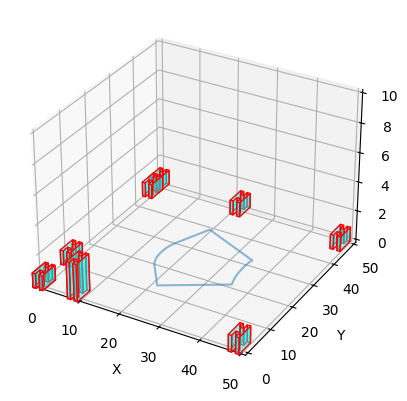

[ 1.          0.          0.         ...  0.21527876 20.
  2.479469  ]
site coverage  0.22890557716953888
Number of collisions:  3
Number of buildings violating interblock distance:  3
Number of buildings outside site:  10  Total buildings:  10
Site coverage within site:  0.0
Site coverage without bounds:  0.2695285773811236
{'n_collisions': 3, 'n_violate_interblock_distance': 3, 'n_outside_site': 10, 'site_coverage_within_site': 0.0, 'site_coverage_no_bounds': 0.2695285773811236}


In [196]:
obs, info = env.reset()
while True:
# for _ in range(1000):
    action, _ = model.predict(obs)
    
    obs, _, done, _, _= env.step(action)
    #reshpare a list to np.array (10x10)
 
    if done:
        # print(np.array(obs[:100]).reshape(10,10))
        # print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        # print('done')
        break

env.render()
print(env.get_info())

In [188]:
env.site_boundary.area
env.building_list[2].area/env.site_boundary.area

0.026952857738112346

In [108]:
env.building_list

[<POLYGON ((-1.219 2.479, -1.219 -2.521, -0.427 -2.521, -0.427 -0.752, 0.518 ...>,
 <POLYGON ((-1.265 2.479, -1.265 -2.521, -0.473 -2.521, -0.473 -0.752, 0.473 ...>,
 <POLYGON ((3.735 28.479, 3.735 23.479, 4.527 23.479, 4.527 25.248, 5.473 25....>,
 <POLYGON ((-1.265 51.479, -1.265 46.479, -0.473 46.479, -0.473 48.248, 0.473...>,
 <POLYGON ((31.735 2.479, 31.735 -2.521, 32.527 -2.521, 32.527 -0.752, 33.473...>,
 <POLYGON ((42.735 2.479, 42.735 -2.521, 43.527 -2.521, 43.527 -0.752, 44.473...>,
 <POLYGON ((-1.265 2.479, -1.265 -2.521, -0.473 -2.521, -0.473 -0.752, 0.473 ...>,
 <POLYGON ((15.735 51.479, 15.735 46.479, 16.527 46.479, 16.527 48.248, 17.47...>,
 <POLYGON ((28.735 2.479, 28.735 -2.521, 29.527 -2.521, 29.527 -0.752, 30.473...>,
 <POLYGON ((-1.265 18.479, -1.265 13.479, -0.473 13.479, -0.473 15.248, 0.473...>,
 <POLYGON ((-1.265 2.479, -1.265 -2.521, -0.473 -2.521, -0.473 -0.752, 0.473 ...>,
 <POLYGON ((-1.265 43.479, -1.265 38.479, -0.473 38.479, -0.473 40.248, 0.473...>,
 <PO

In [109]:
import torch
import time
date = time.strftime("%Y-%m-%d")
save_path = f'ppo_model_v3_{date}.pth'

# Save the entire model
model.save(save_path)

In [110]:
import os
load_path = "../RL/ppo_model_v3_2023-11-22.pth"

# Load the model

if os.path.exists(load_path):
    model = PPO.load(load_path)
    # Continue with your code
else:
    print(f"The file {load_path} does not exist.")

The file ../RL/ppo_model_v3_2023-11-22.pth does not exist.
